# Exercise 1 Image Segmentation with a U-Net

In [1]:
import torch
import pytorch_lightning as pl
import torchvision
from typing import Tuple
from pathlib import Path
from PIL import Image

## Download data and preprocess the data

In [2]:
!wget https://cloud.uol.de/s/tmtBqz4TPDtsPw9/download/cityscapes.tar.gz

--2023-01-22 14:16:55--  https://cloud.uol.de/s/tmtBqz4TPDtsPw9/download/cityscapes.tar.gz
Resolving cloud.uol.de (cloud.uol.de)... 134.106.87.50, 2001:638:705:3f15::50
Connecting to cloud.uol.de (cloud.uol.de)|134.106.87.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102669605 (98M) [application/x-gzip]
Saving to: ‘cityscapes.tar.gz’

cityscapes.tar.gz   100%[===================>]  97.91M   108MB/s    in 0.9s    

2023-01-22 14:16:56 (108 MB/s) - ‘cityscapes.tar.gz’ saved [102669605/102669605]



In [3]:
!tar -xf cityscapes.tar.gz
!mkdir cityscapes
!mv val cityscapes
!mv train cityscapes

In [4]:
class CitySpacesDataset(torch.utils.data.Dataset):
    
    def __init__(self, path: Path) -> None:
        super().__init__()
        self.inputs, self.labels = [], []
        transform = torchvision.transforms.PILToTensor()
        for image in path.glob("*.jpg"):
            i = Image.open(image)
            t = transform(i)
            x,y  = torch.split(t, 256, dim=2)
            self.inputs.append(x)
            self.labels.append(y)

    def __len__(self) -> int:
        return len(self.inputs)
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.inputs[idx], self.labels[idx]

In [5]:
BATCH_SIZE = 128
train_path = Path("./cityscapes/train/")
val_path = Path("./cityscapes/val/")

ds_train = CitySpacesDataset(train_path)
ds_val = CitySpacesDataset(val_path)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
a, b = ds_train[0]

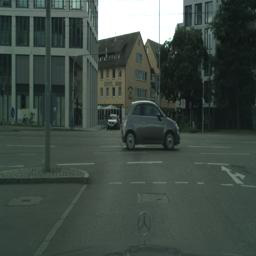

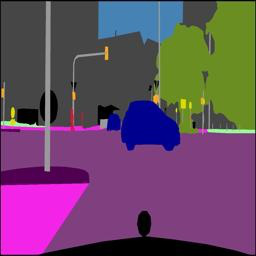

In [7]:
to_pil = torchvision.transforms.ToPILImage()
display(to_pil(a))
display(to_pil(b))

## Model Definition

In [8]:
class DoubleConv(torch.nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(torch.nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(torch.nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 8))
        self.down1 = (Down(8, 16))
        self.down2 = (Down(16, 32))
        self.down3 = (Down(32, 64))
        self.down4 = (Down(64, 128))
        self.up1 = (Up(128, 64))
        self.up2 = (Up(64, 32))
        self.up3 = (Up(32, 16))
        self.up4 = (Up(16, 8))
        self.outc = (OutConv(8, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
import pytorch_lightning as pl
from typing import List, Any
import torchmetrics

class UnetWrapper(pl.LightningModule):

    def __init__(self, 
        loss: callable, 
        lr: float,
        model: torch.nn.Module,
        test_metrics: List[torchmetrics.Metric],
    ) -> None:
        super().__init__()

        self.loss = loss
        self.lr = lr
        
        self.model = model
        
        # eval stuff
        self.test_metrics = test_metrics
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.model(x)
        return out

    def _step(self, batch) -> torch.Tensor:
        x, y = batch
        pred  = self.forward(x.float())
        loss = self.loss(pred, y.float())
        return pred, loss

    def training_step(self, batch) -> torch.Tensor:
        pred, loss = self._step(batch)
        self.log("train/loss", loss)
        return loss
    
    def _eval_step(self, batch, metrics):
        pred, loss = self._step(batch)
        for metric in metrics:
            metric.update(pred, batch[-1])

        return loss

    def _eval_epoch_end(self, eval_type, metrics):
        for metric in metrics:
            value = metric.compute().detach().data
            self.log(f"{eval_type}/{metric.__class__.__name__}:", value)
            print(f"{eval_type} {metric.__class__.__name__}: {value}")
        
    def test_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        loss = self._eval_step(batch, self.test_metrics)

    def test_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Test", self.test_metrics)
                
    def configure_optimizers(self) -> Any:
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optim

## Actucal Training

In [10]:
lr = 1e-3
loss = torch.nn.MSELoss()
EPOCHS = 15

unet = UNet(3, 3)
model = UnetWrapper(loss, lr, unet, [])

In [11]:
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=EPOCHS, log_every_n_steps=10)

In [12]:
trainer.fit(model, train_dataloaders=dl_train)

Training: 0it [00:00, ?it/s]

In [13]:
trainer.test(model, dataloaders=dl_val)

Testing: 0it [00:00, ?it/s]

[{}]

In [14]:
def show_results(image):
    test_image, test_seg = ds_val[image]
    pred_seg = model(test_image.unsqueeze(0).float()).squeeze(0)
    print("Image")
    display(to_pil(test_image))
    print("Target")
    display(to_pil(test_seg))
    print("Prediction")
    display(to_pil(pred_seg))

## Part d)
Visualization and Results  
For example images see the next two cells. 

After that we can see the loss during training and test via tensorboard

Image


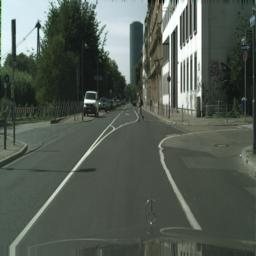

Target


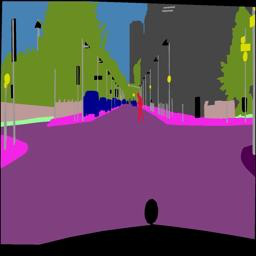

Prediction


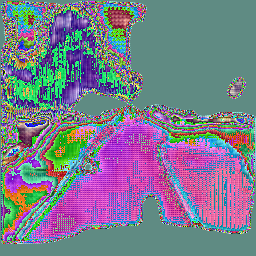

In [15]:
show_results(129)

Image


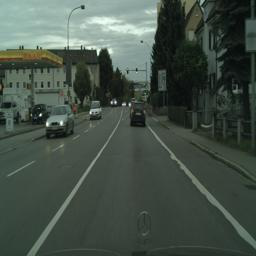

Target


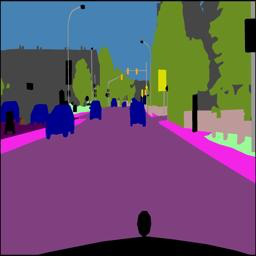

Prediction


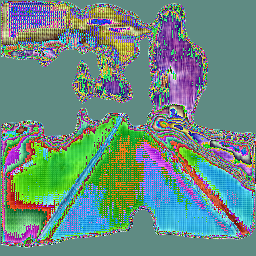

In [16]:
show_results(412)

In [17]:
%load_ext tensorboard

In [18]:
%tensorboard --logdir lightning_logs